In [24]:
# Portfolio link => http://people.brunel.ac.uk/~mastjjb/jeb/orlib/portinfo.html

In [107]:
import pandas as pd
import numpy as np
import urllib.request  # the lib that handles the url stuff
from scipy.optimize import minimize
import random
from itertools import combinations
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [108]:
# url = "http://people.brunel.ac.uk/~mastjjb/jeb/orlib/files/port5.txt"
url = "http://people.brunel.ac.uk/~mastjjb/jeb/orlib/files/port3.txt"

In [109]:
get_data = urllib.request.urlopen(url)
data_array = []
for line in get_data:
    data_array.append(line.decode('utf-8').replace('\n','').strip())

num_of_data = int(data_array[0])
num_of_data

89

In [110]:
mean_and_std = data_array[1:num_of_data+1]
correlation = data_array[num_of_data+1:]

# Convert the data to a list of tuples
data_tuples = [tuple(map(float, row.split())) for row in mean_and_std]
# Create the DataFrame
df_mean_std = pd.DataFrame(data_tuples, columns=['mean_return', 'std_return'])

# Convert the data to a list of tuples
data_tuples = [tuple(map(float, row.split())) for row in correlation]
# Create the DataFrame
df_corr = pd.DataFrame(data_tuples, columns=['asset', 'asset_corr', 'corr'])

In [111]:
df_corr.head()

,asset,asset_corr,corr
0,1.0,1.0,1.000000
1,1.0,2.0,0.169599
2,1.0,3.0,0.282126
3,1.0,4.0,0.256150
4,1.0,5.0,0.420913


In [112]:
df_mean_std["asset"] = df_mean_std.index
df_mean_std["asset"] = df_mean_std.asset.apply(lambda x: x+1)
df_mean_std.head()

,mean_return,std_return,asset
0,0.003748,0.034225,1
1,0.005254,0.030476,2
2,0.003050,0.036061,3
3,0.002232,0.044729,4
4,0.004411,0.037047,5


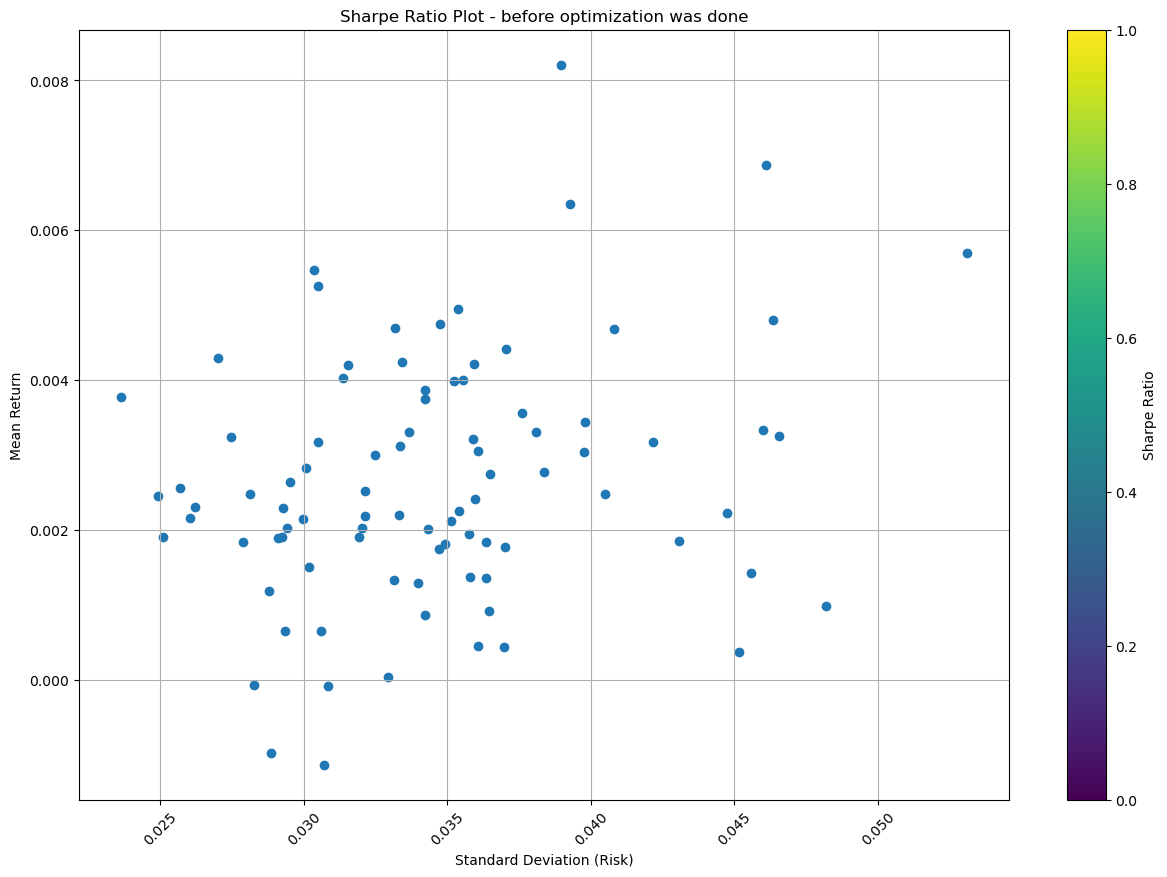

In [113]:
# Plot the scatter plot
plt.figure(figsize=(15,10))
plt.scatter(df_mean_std['std_return'], df_mean_std['mean_return'])
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation (Risk)')
plt.xticks(rotation=45)
plt.ylabel('Mean Return')
plt.title('Sharpe Ratio Plot - before optimization was done')
plt.grid(True)
plt.show()

Portfolio optimization is a classic problem in finance, where the aim is to find the optimal allocation of assets in a portfolio to achieve the highest return while minimizing risk. I use Multi-Objective Genetic Algorithm (MOGA) to find the Pareto-optimal solutions, which represent the trade-offs between return and risk.

Before proceeding, I will define the objective functions for our MOGA implementation:

Objective 1 (Maximize Mean Return):    **maximize f1(x) = mean_return(x)**


Objective 2 (Minimize Standard Deviation of Return):   **minimize f2(x) = std_return(x)**


Where x is the portfolio allocation vector.

I will implement the MOGA along with an archive for storing non-dominated solutions and relevant solution generation and selection operators

In [114]:
# Transposing the correlation between assets

correlations_df = df_corr.copy()
correlations_df.columns = ['Asset 1', 'Asset 2', 'Correlation']
correlations_df.reset_index(drop=True, inplace=True)

# Transpose the correlations DataFrame
correlations_transposed_df = correlations_df.pivot_table(index='Asset 1', columns='Asset 2', values='Correlation')

# Fill NaN values in the transposed DataFrame with the corresponding values from the original DataFrame
correlations_filled_df = correlations_transposed_df.combine_first(correlations_df.pivot_table(index='Asset 2', columns='Asset 1', values='Correlation'))


correlations_filled_df.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0
Asset 1,,,,,,,,,,,,,,,,,,,,,
1.0,1.000000,0.169599,0.282126,0.256150,0.420913,0.493473,0.383985,0.342678,0.227698,0.341189,...,0.446822,0.398948,0.123455,0.310327,0.235339,0.241057,0.365122,0.196632,0.325126,0.147102
2.0,0.169599,1.000000,0.108874,0.168115,0.266227,0.291169,0.156167,0.146791,0.108278,0.218066,...,0.256520,0.190120,0.099085,0.232593,0.159448,0.157207,0.239582,0.043924,0.106626,0.071266
3.0,0.282126,0.108874,1.000000,0.080148,0.246958,0.260795,0.286037,0.141441,0.148070,0.206515,...,0.135432,0.188495,0.133714,0.150469,0.117481,0.121911,0.201234,0.139643,0.209157,0.123615
4.0,0.256150,0.168115,0.080148,1.000000,0.307325,0.324102,0.301013,0.379879,0.355954,0.173163,...,0.285746,0.247382,0.451338,0.249820,0.226710,0.257971,0.283305,0.332236,0.312144,0.301345
5.0,0.420913,0.266227,0.246958,0.307325,1.000000,0.573651,0.273283,0.334155,0.210999,0.321043,...,0.408829,0.332569,0.174326,0.277029,0.257568,0.187951,0.301556,0.158283,0.326521,0.185856


In [115]:

df = df_mean_std.copy()
correlation_df = correlations_filled_df.copy()

# Function to calculate portfolio return and risk with correlations
def calculate_portfolio_metrics(allocations, correlation_matrix):
    mean_return = np.dot(allocations, df['mean_return'])
    covariance_matrix = correlation_matrix * np.outer(df['std_return'], df['std_return'])
    portfolio_variance = np.dot(allocations.T, np.dot(covariance_matrix, allocations))
    portfolio_std_dev = np.sqrt(portfolio_variance)
    return mean_return, portfolio_std_dev

# Function to generate initial population
def generate_population(population_size, num_assets):
    population = []
    for _ in range(population_size):
        allocations = np.random.random(num_assets)
        allocations /= np.sum(allocations)  # Normalize to sum to 1
        population.append(allocations)
    return population

# Function to perform tournament selection
def tournament_selection(population, tournament_size):
    tournament = random.sample(population, tournament_size)
    return max(tournament, key=lambda x: objective_functions(x))

# Function to perform crossover
def crossover(parent1, parent2, crossover_rate):
    if random.random() < crossover_rate:
        index = random.randint(1, len(parent1) - 1)
        child1 = np.concatenate((parent1[:index], parent2[index:]))
        child2 = np.concatenate((parent2[:index], parent1[index:]))
        return child1, child2
    return parent1, parent2

# Function to perform mutation
def mutation(individual, mutation_rate):
    if random.random() < mutation_rate:
        mutation_index = random.randint(0, len(individual) - 1)
        individual[mutation_index] = random.random()
        individual /= np.sum(individual)  # Normalize to sum to 1
    return individual

# Objective functions
def objective_functions(allocations):
    mean_return, std_return = calculate_portfolio_metrics(allocations, correlation_df)
    return mean_return, std_return

# MOGA function
def moga(population_size, num_generations, tournament_size, crossover_rate, mutation_rate):
    population = generate_population(population_size, len(df))
    archive = []

    for generation in range(num_generations):
        offspring = []

        while len(offspring) < population_size:
            parent1 = tournament_selection(population, tournament_size)
            parent2 = tournament_selection(population, tournament_size)

            child1, child2 = crossover(parent1, parent2, crossover_rate)

            child1 = mutation(child1, mutation_rate)
            child2 = mutation(child2, mutation_rate)

            offspring.extend([child1, child2])

        population = offspring

        # Non-dominated sorting
        non_dominated_solutions = []
        for individual in population:
            is_dominated = False
            for other_individual in population:
                if all(individual >= other_individual) and any(individual > other_individual):
                    is_dominated = True
                    break
            if not is_dominated:
                non_dominated_solutions.append(individual)

        # Update archive
        archive.extend(non_dominated_solutions)

    return archive

# Parameters for usaing MOGA
population_size = 30
num_generations = 80
tournament_size = 5
crossover_rate = 0.9
mutation_rate = 0.3

archive = moga(population_size, num_generations, tournament_size, crossover_rate, mutation_rate)

# accumulate results with assets and asset allocations
sol_mean_std = []
df_asset_mean_std = df_mean_std.copy()
print("Pareto-optimal solutions started")
for i, solution in enumerate(archive):
    mean_return, std_return = calculate_portfolio_metrics(solution, correlation_df)
    asset_allocation = list(zip(df['asset'], solution))
    
    allocations_df = pd.DataFrame(asset_allocation, columns=["asset", "weight"])
    df_asset_mean_std[f"weight_{i}"] = allocations_df["weight"]
    
    sol_mean_std.append([f"solution_{i}", f"{mean_return:.6f}", f"{std_return:.6f}"])

print("Completed !!!")

Pareto-optimal solutions started
Completed !!!


In [133]:
df_sol_mean_std = pd.DataFrame(sol_mean_std, columns=["solution", "mean_return", "std_return"])
df_sol_mean_std.head()

,solution,mean_return,std_return
0,solution_0,0.002674,0.017326
1,solution_1,0.002926,0.017957
2,solution_2,0.001477,0.019937
3,solution_3,0.002846,0.017670
4,solution_4,0.002674,0.016798


In [134]:
len(df_sol_mean_std), len(df_asset_mean_std)

(1802, 89)

In [135]:
df_asset_mean_std.head()

,mean_return,std_return,asset,weight_0,weight_1,weight_2,weight_3,weight_4,weight_5,weight_6,...,weight_1792,weight_1793,weight_1794,weight_1795,weight_1796,weight_1797,weight_1798,weight_1799,weight_1800,weight_1801
0,0.003748,0.034225,1,0.005458,0.001990,0.008550,0.005335,0.024042,0.007837,0.020211,...,0.021455,0.009813,0.011191,0.012099,0.008925,0.011510,0.011720,0.012465,0.008067,0.011036
1,0.005254,0.030476,2,0.010178,0.006144,0.006104,0.023047,0.017244,0.003439,0.001173,...,0.006703,0.003066,0.003496,0.003780,0.002789,0.003596,0.003662,0.003894,0.002520,0.003448
2,0.003050,0.036061,3,0.000025,0.010218,0.007060,0.009124,0.014024,0.004553,0.011924,...,0.004255,0.001946,0.002219,0.002399,0.001770,0.002283,0.002324,0.002472,0.001600,0.002189
3,0.002232,0.044729,4,0.020624,0.007687,0.003744,0.001307,0.000881,0.001048,0.021174,...,0.008262,0.003779,0.004310,0.004660,0.003437,0.004433,0.004513,0.004800,0.003107,0.004250
4,0.004411,0.037047,5,0.004142,0.017485,0.007725,0.009053,0.015848,0.005446,0.021780,...,0.001659,0.000759,0.000866,0.000936,0.000690,0.000890,0.000906,0.000964,0.000624,0.000854


##### Note: 
- If you are using solution_0 from df_sol_mean_std, then the weight_0 from df_asset_mean_std applies
- If you are using solution_1 from df_sol_mean_std, then the weight_1 from df_asset_mean_std applies
- ......

In [147]:
sort_by = "mean_return"  # it can be sort by mean_return or std_return
mean_std_sorted = df_sol_mean_std.sort_values(by=sort_by, ascending=True)
mean_std_sorted.reset_index(drop=True, inplace=True) 
mean_std_sorted.head()

,solution,mean_return,std_return
0,solution_16,0.001457,0.020682
1,solution_2,0.001477,0.019937
2,solution_36,0.001805,0.019141
3,solution_20,0.001805,0.019141
4,solution_52,0.001929,0.012445


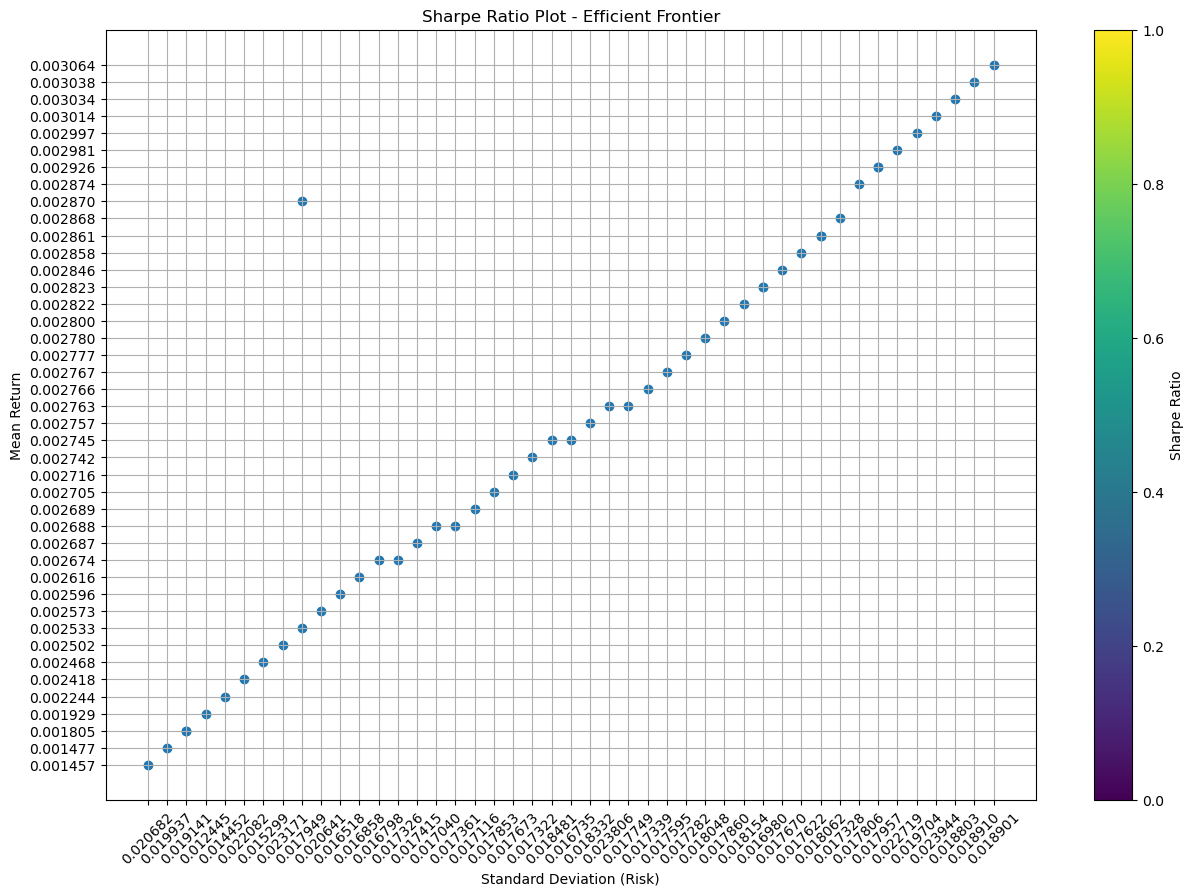

In [155]:
dplot = mean_std_sorted[:50]


# Plot the scatter plot
plt.figure(figsize=(15,10))
plt.scatter(dplot['std_return'], dplot['mean_return'])
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation (Risk)')
plt.xticks(rotation=45)
plt.ylabel('Mean Return')
plt.title('Sharpe Ratio Plot - Efficient Frontier')
plt.grid(True)
plt.show()

In [156]:
sort_by = "std_return"  # it can be sort by mean_return or std_return
mean_std_sorted = df_sol_mean_std.sort_values(by=sort_by, ascending=False)
mean_std_sorted.head()

,solution,mean_return,std_return
901,solution_901,0.009007,0.042444
1435,solution_1435,0.009007,0.042444
679,solution_679,0.009007,0.042444
680,solution_680,0.009007,0.042444
681,solution_681,0.009007,0.042444


**************** Top 10 assets in the portfolio across 9 solutions ********************** 





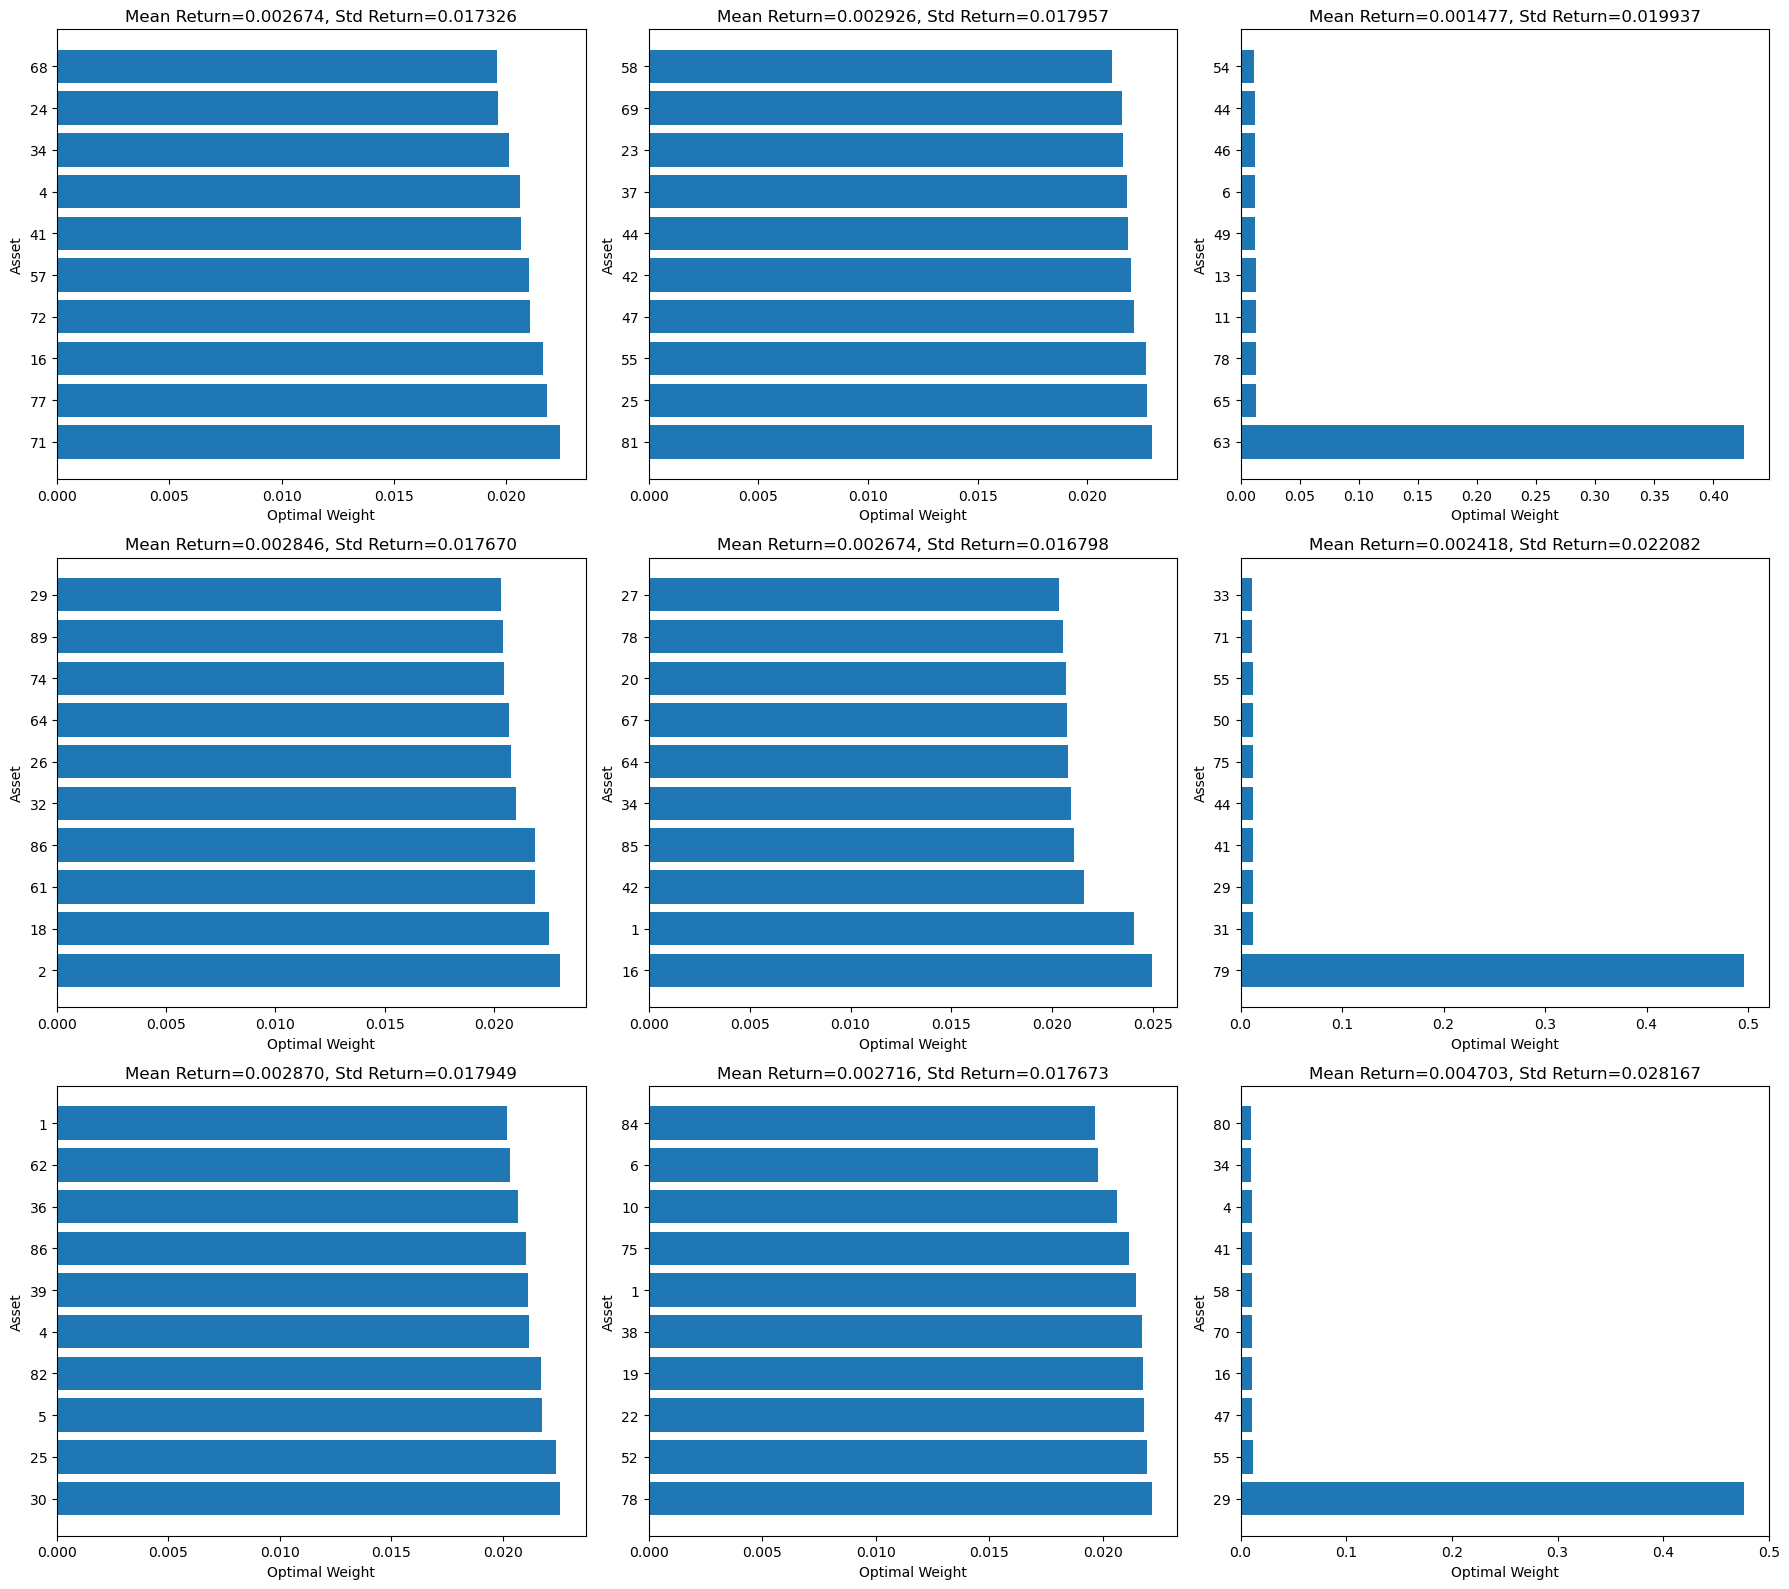

In [157]:
data_len = 9  # can also be len(mean_std_sorted)

print(f'**************** Top 10 assets in the portfolio across {data_len} solutions ********************** \n')
print("\n")

fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(top=0.92)

rows_ = int(round(data_len/3))
cols_ = 3

i = 0

for index, row in df_sol_mean_std[:data_len].iterrows():
    plt.subplot(rows_, cols_, i+1)
    sorted_val = df_asset_mean_std.sort_values(by=f"weight_{index}", ascending=False)
    sorted_val["asset"] = sorted_val['asset'].astype(str)
    
    plt.barh(sorted_val['asset'][:10], sorted_val[f'weight_{index}'][:10])
    plt.xlabel('Optimal Weight')
    plt.ylabel('Asset')
    plt.title(f'Mean Return={row["mean_return"]}, Std Return={row["std_return"]}')
    i += 1


fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
# fig.suptitle(f'Top 10 assets in the portfolio accross {data_len} solutions', fontsize=16, y = 0.92)
plt.show()